In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import scipy.stats as ss
from scipy.interpolate import interp1d
from fractions import Fraction
from empiricaldist import Pmf, Cdf
import matplotlib.pyplot as plt
from collections import Counter

In [3]:
df = pd.read_csv(Path.cwd() / 'data' / 'penguins_raw.csv')
df.shape

(344, 17)

In [17]:
def make_cdf_map(df, colname, by='Species'):
    fig, ax = plt.subplots(1, 1, figsize=(12, 3))
    cdf_map = {}
    grouped = df.groupby(by)[colname]
    for species, group in grouped:
        cdf_map[species] = Cdf.from_seq(group, name=species)
        ax.plot(cdf_map[species], label=species)
    plt.legend()
    return cdf_map

{'Adelie Penguin (Pygoscelis adeliae)': 32.1    0.006623
 33.1    0.013245
 33.5    0.019868
 34.0    0.026490
 34.1    0.033113
           ...   
 43.2    0.966887
 44.1    0.980132
 45.6    0.986755
 45.8    0.993377
 46.0    1.000000
 Name: , Length: 78, dtype: float64,
 'Chinstrap penguin (Pygoscelis antarctica)': 40.9    0.014706
 42.4    0.029412
 42.5    0.058824
 43.2    0.073529
 43.5    0.088235
 45.2    0.117647
 45.4    0.132353
 45.5    0.147059
 45.6    0.161765
 45.7    0.191176
 45.9    0.205882
 46.0    0.220588
 46.1    0.235294
 46.2    0.250000
 46.4    0.279412
 46.5    0.294118
 46.6    0.308824
 46.7    0.323529
 46.8    0.338235
 46.9    0.352941
 47.0    0.367647
 47.5    0.382353
 47.6    0.397059
 48.1    0.411765
 48.5    0.426471
 49.0    0.455882
 49.2    0.470588
 49.3    0.485294
 49.5    0.500000
 49.6    0.514706
 49.7    0.529412
 49.8    0.544118
 50.0    0.558824
 50.1    0.573529
 50.2    0.602941
 50.3    0.617647
 50.5    0.647059
 50.6    0.6617

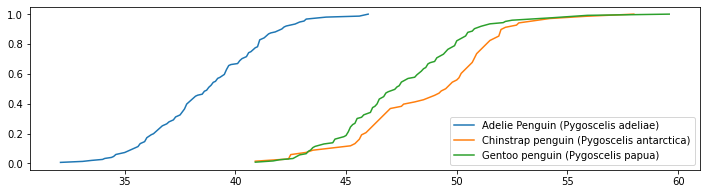

In [18]:
make_cdf_map(df, 'Culmen Length (mm)')

In [19]:
def make_norm_map(df, colname, by='Species'):
    norm_map = {}
    grouped = df.groupby(by)[colname]
    for species, group in grouped:
        mean = group.mean()
        std = group.std()
        norm_map[species] = ss.norm(mean, std)
    return norm_map

In [21]:
flipper_map = make_norm_map(df, 'Flipper Length (mm)')
flipper_map

{'Adelie Penguin (Pygoscelis adeliae)': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x18f0aa37e20>,
 'Chinstrap penguin (Pygoscelis antarctica)': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x18f0a931060>,
 'Gentoo penguin (Pygoscelis papua)': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x18f68bd8ca0>}

In [22]:
data = 193
hypos = flipper_map.keys()
likelihood = [flipper_map[hypo].pdf(data) for hypo in hypos]
likelihood

[0.054732511875530694, 0.051721356158881626, 5.866045366199098e-05]

In [23]:
prior = Pmf(1/3, hypos)
posterior = prior * likelihood
posterior.normalize()
posterior

,probs
Adelie Penguin (Pygoscelis adeliae),0.513860
Chinstrap penguin (Pygoscelis antarctica),0.485589
Gentoo penguin (Pygoscelis papua),0.000551


In [24]:
def update_penguin(prior, data, norm_map):
    hypos = prior.qs
    likelihood = [norm_map[hypo].pdf(data) for hypo in hypos]
    posterior = prior * likelihood
    posterior.normalize()
    return posterior

In [26]:
culmen_map = make_norm_map(df, 'Culmen Length (mm)')

In [27]:
posterior1 = update_penguin(prior, 193, flipper_map)
posterior2 = update_penguin(posterior1, 48, culmen_map)
posterior2

,probs
Adelie Penguin (Pygoscelis adeliae),0.003455
Chinstrap penguin (Pygoscelis antarctica),0.995299
Gentoo penguin (Pygoscelis papua),0.001246
